# Experiment 1.4
Carrying on from experiment 1.3. We will repeat the idea of 1.3, but chop off the output side of the network to expose the pre-pooled activations. This is a process of increasing the resolution that we are investigating.

In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic
import nncolor as nc
import nncolor.data
import torchinfo
import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os
import torch.hub
from collections import namedtuple

In [2]:
import IPython
def imshow(img):
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 

In [3]:
# Choose CPU or GPU.
#device = (torch.device("cuda:0") if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")
#device = "cpu"

## 1. Model (resnet)
First, let's double check the model summary.

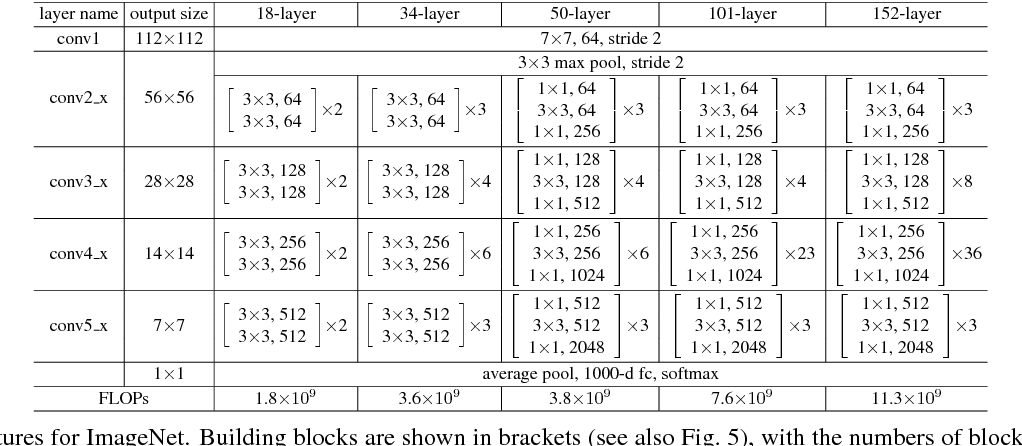

Another model visualization can be seen  at: 
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [4]:
model_ft = tv.models.resnet18(pretrained=True)
torchinfo.summary(model_ft, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## 2. Dataset
The dataset generation code has been moved out into a Python package, `nncolor`. Below, we 
take a moment to investigate the data.

In [128]:
GRID_SHAPE = (7, 7)
NUM_CELLS = np.prod(GRID_SHAPE)
IMG_SHAPE = (224, 224, 3)
cell_shape = nc.data.cell_shape(GRID_SHAPE, IMG_SHAPE)
assert np.array_equal(cell_shape, (32, 32))
# Choosing a diameter less than cell width/height.
# Let's go with 20 (so radius is 10)
RADIUS = 10
BATCH_SIZE = 4

In [6]:
def demo_data():
    FPS = 2
    frames, labels = nc.data.create_samples(30, radius=RADIUS, grid_shape=GRID_SHAPE, 
                                            img_shape=IMG_SHAPE)
    frames = [f*255 for f in frames]
    x_clip = mpe.ImageSequenceClip(frames, fps=2)
    y_clip = mpe.TextClip('WB-0', font='DejaVu-Sans')

    class FrameText(mpe.VideoClip):
        def __init__(self, text, fps):
            def make_frame(f):
               return mpe.TextClip(text[int(f)], font='DejaVu-Sans', color='white').get_frame(f)
            self.duration = 1.0 * len(text) / fps
            mpe.VideoClip.__init__(self, make_frame=make_frame, duration=self.duration)

    y_clip =   FrameText(labels, FPS)
    label_clip = mpe.CompositeVideoClip([mpe.ImageClip(np.zeros(nc.data.DEFAULT_IMG_SHAPE), duration=5), y_clip])
    comp_clip = mpe.clips_array([[y_clip],[x_clip]])
    return comp_clip
clip = demo_data() 
clip.ipython_display()

t:  13%|█▎        | 4/30 [00:00<00:00, 29.89it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


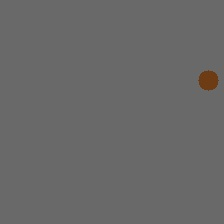

ic| sample['label']: 0
ic| sample['label_grid']: array([[3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 0],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3]])
ic| sample['position']: 20


In [7]:
def test_dataset():
    train, test, val = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered, 
                                      RADIUS, GRID_SHAPE, IMG_SHAPE)
    sample = val[7]
    imshow(sample['image'])
    ic(sample['label'])
    ic(sample['label_grid'])
    ic(sample['position'])
test_dataset()

In [8]:
a = np.array([[0,1, 2],[3,4,5],[6,7,8]])
ic(a)
co = np.array([0, 1])
a[tuple(co)]

ic| a: array([[0, 1, 2],
              [3, 4, 5],
              [6, 7, 8]])


1

## 3. Customize the model
We want to have a model with the fully connected layer removed, and for that, it seems easiest to subclass and override.

In [9]:
class PoolHeadResNet(tv.models.ResNet):
    def __init__(self, train_all_params=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_classes = nc.data.NUM_CLASSES
        # First, disable all other parameters.
        if not train_all_params:
            for param in self.parameters():
                param.requires_grad = False
        # A 1x1 convolution, representing effectively a fully connected, sub-batched at 7x7.
        self.fc2 = torch.nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1,stride=1)
        
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Stop above.
        #x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)
        x = self.fc2(x)
        return x
    
train_all_params = True
model18 = PoolHeadResNet(train_all_params, tv.models.resnet.BasicBlock, [2, 2, 2, 2])
state = torch.hub.load_state_dict_from_url(tv.models.resnet.model_urls['resnet18'])
model18.load_state_dict(state, strict=False);

### 3.1 Modified model summary
The modified model can be seen to have a final layer with output shape [Batch, 4, 7, 7] representing 7x7 individual 4-class classification outputs.

In [10]:
torchinfo.summary(model18, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
PoolHeadResNet                           --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### 3.2 Check that initialization of the new layer
Double check that our new layer has been initialized

In [11]:
model18.fc2.weight[0][0:10]

tensor([[[-0.0019]],

        [[-0.0398]],

        [[ 0.0297]],

        [[ 0.0420]],

        [[-0.0303]],

        [[ 0.0173]],

        [[-0.0126]],

        [[-0.0175]],

        [[-0.0370]],

        [[ 0.0293]]], device='cuda:0', grad_fn=<SliceBackward>)

All looks good! Now design the loss function.

## 4. Loss function
The best loss function to use is not obvious. On one extreme, we can weight all 49 outputs equally as 49 equal predictions to which we apply cross entropy loss. However, this will heavily weight the model caring only about the background, which is always a "3" for neither orange or brown. Alternatively, we could weight only the activation mapped to the dot position. A loss that is a balance of these extremes is also possible.

I try the two extreme losses. I also try two weighted losses that sit in the middle.

### 4.1 Equal weighting
We can extend the MLE/cross-entropy loss used in the previous experiment. If we treat each of the 49 (7x7) outputs as a classification output, then each forward pass now involves 49 different results that form a sort of "sub-batch". We need to take care that our use of the standard loss function is working correctly with this increased output dimension. Below is a brief demo of how the API can be used to achieve the correct result.
The `CrossEntropyLoss` function luckily supports multidimensional input/outputs in the way I need:

In [12]:
# Tesing out a loss function
# 4x2x2 (smaller test version of our 7x7x4).
fc_in = torch.tensor([# batch
    [ # 4x2x2
        [[-0.3, 0.0], [0.3, 3.2] ], # 2x2
        [[ 4.0, 0.1], [-4., 1.1] ], # 2x2
        [[ 7.0, 0.4], [2.0, -.4] ], # 2x2
        [[ 2.1, 4.1], [2.2, 4.1] ], # 2x2
    ]
], dtype=torch.float)
target = torch.tensor([ # batch
    [[0, 1], [1, 1]] # 2x2
], dtype=torch.long)
# We can view all 4 classification losses:
loss = torch.nn.CrossEntropyLoss(reduction='none') 
output = loss(fc_in, target)
ic(output)
# Or we can reduce them to a single number.
loss = torch.nn.CrossEntropyLoss(reduction='mean') 
output = loss(fc_in, target)
ic(output)

ic| output: tensor([[[7.3563, 4.0579],
                     [6.8782, 3.3835]]])
ic| output: tensor(5.4190)


tensor(5.4190)

As a loss function, the 49 sub-batch MLE loss is implemented like below. The extra `pos` and `mask` arguments as the later loss functions use these extra arguments.

In [13]:
def mle(input_, target, pos, mask):
    """Loss function where each output unit is a classification."""
    return torch.nn.functional.cross_entropy(input_, target, reduction='mean')

### 4.2 MLE loss (background-foreground balance weighting)
This weighting gives the 48 units associated with the background a weighting of 1 and gives the
the single unit associated with the dot a weighting of 48.

When an equal weighting is used, the model can get an accuracy of about 48/49 if it always classifies all of the 49 outputs as "neither". This loss tries to correct for this issue. 

In [29]:
def mle_balanced(input_, target, pos, mask):
    """48 weight for the dot-cell, 1 weight for each 48 background 48 cells.""" 
    loss = torch.nn.functional.cross_entropy(input_, target, reduction='none')
    loss_weight = torch.mul(mask, NUM_CELLS - 2) + torch.ones(mask.shape).to(device)
    loss = torch.mul(loss, loss_weight)
    loss = torch.mean(loss)
    return loss

### 4.3 Dot only
This loss is a MLE loss that only considers the output unit that is associated with the
dot position. All other outputs are ignored. 

An obvious issue with this loss is that there is no incentive for the model to correctly
classify the background color. This is a loss that should give the model great leniency 
towards maximizing accuracy of the dot color classification at the expense of the background
color classification.

In [15]:
def mle_dot(input_, target, pos, mask):
    """MLE loss considering only the output unit associated with the dot position."""
    loss = torch.nn.functional.cross_entropy(input_, target, reduction='none')
    dot_loss = torch.mul(mask, loss) 
    dot_loss = torch.mean(loss)
    return dot_loss

### 4.3 MLE loss (radial weighted) 
MLE loss for each of the 49 outputs, with the loss weighted based on the distance to the dot. This is like the first loss above, except we have introduced a more complex weighting function.


In [16]:
# Cache the computation of radial loss weighting. This is used
# in the below loss function.
radial_loss = nc.data.radial_weight_for_every_pos(GRID_SHAPE, max_dist=5, 
                                                rate_fctn=nc.data.ease_in_out_sine)
radial_loss[np.array([0,4])].shape
radial_loss = torch.from_numpy(radial_loss).to(device)

def mle_radial(input_, target, pos, mask):
    loss = torch.nn.functional.cross_entropy(input_, target, reduction='none')
    loss_weight = radial_loss[pos]
    dot_loss = torch.mul(loss_weight, loss) 
    dot_loss = torch.mean(loss)
    return dot_loss

## Training
Training loop.

In [133]:
# Copied from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization
data_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
train_ds, test_ds, val_ds = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered,
                                                        dot_radius=RADIUS,
                                                        grid_shape=GRID_SHAPE)
train_ds.transform = data_transform
val_ds.transform = data_transform
test_ds.transform = data_transform
ds = {'train': train_ds, 'val': val_ds, 'test': test_ds}
dataloaders = {x: torch.utils.data.DataLoader(ds[x], batch_size=BATCH_SIZE, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(ds[x]) for x in ['train', 'val', 'test']}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_dot_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)
                label_grids = batch['label_grid'].to(device)
                mask_grids = batch['mask_grid'].to(device)
                pos = batch['position'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, label_grids, pos, mask_grids)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred_correct = preds == label_grids.data
                pred_dot_correct = torch.mul(pred_correct, mask_grids)
                running_corrects += torch.sum(pred_correct)
                running_dot_corrects += torch.sum(pred_dot_correct)
            if phase == 'train':
                scheduler.step()

            denom = dataset_sizes[phase] * NUM_CELLS
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects.double() / denom
            epoch_dot_acc = running_dot_corrects / dataset_sizes[phase]

            print('{} Loss: {:.5f} Acc: {:.5f} Dot Acc: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_dot_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # NO! should be model with least loss
    #model.load_state_dict(best_model_wts)
    return model

In [135]:
def debug_model(model):
    # 3: hard
    # 9: blank
    # 10: orange
    # 14: easy, but machine performs poorly.
    interesting_samples = [test_ds[i] for i in (3, 8, 9, 10, 12, 13, 14, 17)]
    for s in interesting_samples:
        img = s['image']
        label_grid = s['label_grid']
        sp = nc.data.cell_shape(label_grid.shape, img.shape)
        input_ = torch.unsqueeze(data_transform(img), 0)
        input_ = input_.to(device)
        output = model(input_)
        ans = torch.argmax(output, 1)[0]
        ic(s['label'])
        ans = ans.cpu().detach().numpy()
        nc.data.draw_overlay(img, ans)
        imshow(img)

## Accuracy print out
To explore the nature of the preductions, I want an array with dimensions (label, prediction) and values are tallies. Accuracy for each label is then the diagonal divided by the sum along the prediction dimension. Overall accuracy is the sum along the diagonal divided by the complete sum. 

Below is some code that was used to test out how to implement this. 

In [137]:
def _test_code():
    acc = torch.zeros((4,4), dtype=torch.long)
    res, label = [torch.rand((2, 4, 7, 7)), 
                  torch.randint(0, 4, (2, 7, 7))]
    norml = torch.sum(res, dim=1)
    norml = norml.unsqueeze(1)
    res = res / norml
    _, p = torch.max(res, 1)
    label = torch.flatten(label)
    p = torch.flatten(p)
    # put_ requires linear indexes, which is a bit strange.
    # https://pytorch.org/docs/master/generated/torch.Tensor.put_.html#torch.Tensor.put_
    linear_indexes = label*4 + p 
    ones = torch.LongTensor([1]).expand_as(linear_indexes)
    return acc.put_(linear_indexes, ones, accumulate=True)
_test_code()

tensor([[ 4, 10,  6, 11],
        [ 5,  7,  4,  7],
        [ 5,  5,  3,  7],
        [ 8,  8,  6,  2]])

The actual accuracy investigation code is implemented below.

In [146]:
def test_model(model):
    model.eval()
    accuracy = None
    dot_accuracy = None
    accuracy_details = torch.zeros((nc.data.NUM_CLASSES, nc.data.NUM_CLASSES))
    dot_accuracy_details = torch.zeros((nc.data.NUM_CLASSES, nc.data.NUM_CLASSES))
    ones = torch.ones(BATCH_SIZE*NUM_CELLS, dtype=torch.long)
    for batch in dataloaders['test']:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        pos = batch['position'].to(device)
        mask_grids = batch['mask_grid'].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Accuracy breakdown for all units. 
        labelf = torch.full((BATCH_SIZE, NUM_CELLS), 3)
        batch_pos = torch.stack((torch.LongTensor([0, 1, 2, 3]).to(device), pos))
        labelf[pos] = labels
        labelf = torch.flatten(labelf)
        #labelf = torch.full((BATCH_SIZE, *GRID_SHAPE, nc.data.LABEL_TO_COLOR_ID['neither'])
        predf = torch.flatten(preds)
        ic((labelf.shape, predf.shape))
        linear_indexes = labelf * nc.data.NUM_CLASSES + predf
        accuracy_details.put_(linear_indexes, ones, accumulate=True)
    print(accuracy_details)
        

### 49-cell cross-entropy loss

In [147]:
model = models[1]
test_model(model)

RuntimeError: shape mismatch: value tensor of shape [4] cannot be broadcast to indexing result of shape [4, 49]

Testing loss: Dot
Epoch 0/3
----------
train Loss: 0.00002 Acc: 0.99977 Dot Acc: 0.98866
val Loss: 0.00009 Acc: 0.99832 Dot Acc: 0.91752

Epoch 1/3
----------
train Loss: 0.00001 Acc: 0.99992 Dot Acc: 0.99632
val Loss: 0.00010 Acc: 0.99833 Dot Acc: 0.91837

Epoch 2/3
----------
train Loss: 0.00001 Acc: 0.99997 Dot Acc: 0.99844
val Loss: 0.00010 Acc: 0.99847 Dot Acc: 0.92517

Epoch 3/3
----------
train Loss: 0.00001 Acc: 0.99999 Dot Acc: 0.99929


ic| s['label']: 0


val Loss: 0.00010 Acc: 0.99840 Dot Acc: 0.92177

Training complete in 1m 54s
Best val Acc: 0.998473


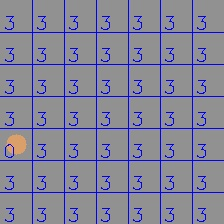

ic| s['label']: 0


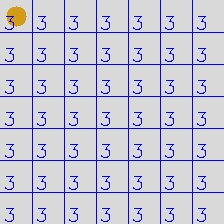

ic| s['label']: 3


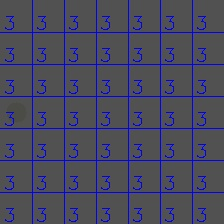

ic| s['label']: 0


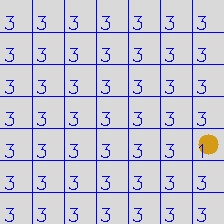

ic| s['label']: 3


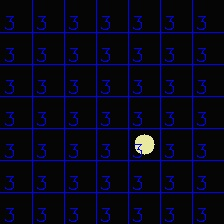

ic| s['label']: 3


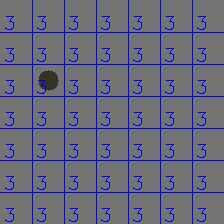

ic| s['label']: 3


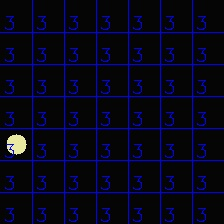

ic| s['label']: 1


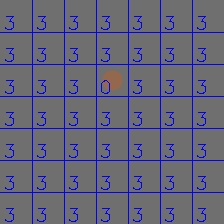

Testing loss: Radial
Epoch 0/3
----------
train Loss: 0.00000 Acc: 1.00000 Dot Acc: 1.00000
val Loss: 0.00010 Acc: 0.99856 Dot Acc: 0.92942

Epoch 1/3
----------
train Loss: 0.00000 Acc: 1.00000 Dot Acc: 1.00000
val Loss: 0.00011 Acc: 0.99859 Dot Acc: 0.93112

Epoch 2/3
----------
train Loss: 0.00000 Acc: 1.00000 Dot Acc: 1.00000
val Loss: 0.00011 Acc: 0.99865 Dot Acc: 0.93367

Epoch 3/3
----------
train Loss: 0.00000 Acc: 1.00000 Dot Acc: 1.00000


ic| s['label']: 0


val Loss: 0.00011 Acc: 0.99856 Dot Acc: 0.92942

Training complete in 1m 55s
Best val Acc: 0.998646


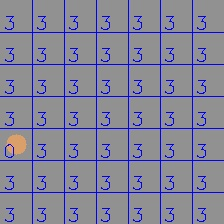

ic| s['label']: 0


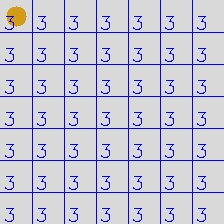

ic| s['label']: 3


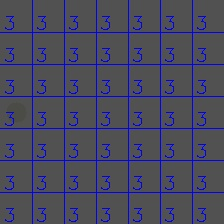

ic| s['label']: 0


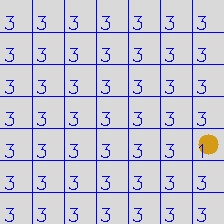

ic| s['label']: 3


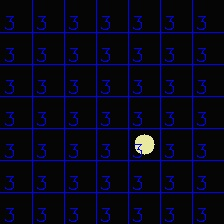

ic| s['label']: 3


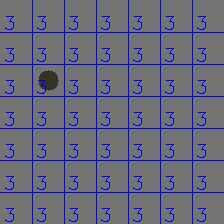

ic| s['label']: 3


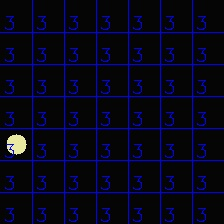

ic| s['label']: 1


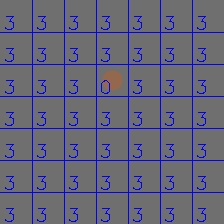

In [28]:
LossTest = namedtuple('LossTest', ['name', 'fctn', 'num_epochs'])
losses = [
    LossTest('MLE',      mle,          0),
    LossTest('Balanced', mle_balanced, 0),
    LossTest('Dot',      mle_dot,      4),
    LossTest('Radial',   mle_radial,   4)]
models = []
for loss in losses:
    if not loss.num_epochs:
        continue
    print(f"Testing loss: {loss.name}")
    model = model18.to(device)
    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model = train_model(model, loss.fctn, optimizer_ft, exp_lr_scheduler, 
                        num_epochs=loss.num_epochs)
    models.append(model)
    debug_model(model)

ic| s['label']: 3


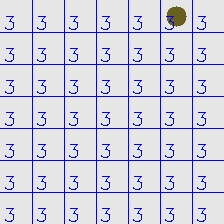

ic| s['label']: 3


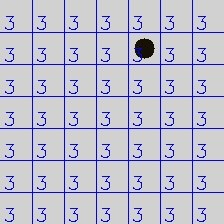

ic| s['label']: 3


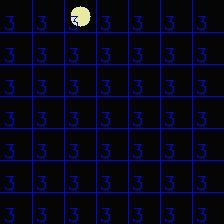

ic| s['label']: 3


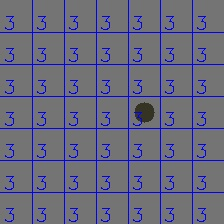

ic| s['label']: 3


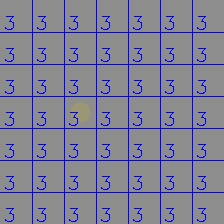

ic| s['label']: 3


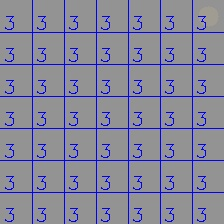

ic| s['label']: 0


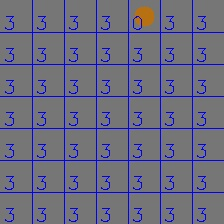

ic| s['label']: 3


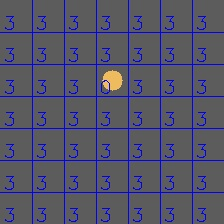

ic| s['label']: 3


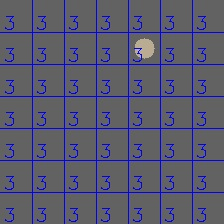

ic| s['label']: 3


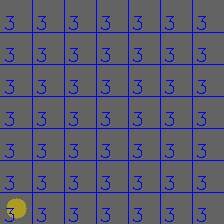

In [31]:
interesting_samples = [test_ds[i] for i in range(30,40)]
model = models[1]
for s in interesting_samples:
    img = s['image']
    label_grid = s['label_grid']
    sp = nc.data.cell_shape(label_grid.shape, img.shape)
    input_ = torch.unsqueeze(data_transform(img), 0)
    input_ = input_.to(device)
    output = model(input_)
    ans = torch.argmax(output, 1)[0]
    ic(s['label'])
    ans = ans.cpu().detach().numpy()
    nc.data.draw_overlay(img, ans)
    imshow(img)

## Results
After 10 epochs, we have 99% accuracy. Looking at the accuracy metric shows that it's not very useful: an accuracy of 48/49=98% can be achieved by just returning 0 for every square. To get a better idea of the performance, let's take a look at some specific examples.

## Example input/outputs

From the above examples, it can be seen that the model is roughly performing the desired task; however, I don't think it could be said that it's very accurate. We need a better scoring function to represent the performance of the model. I'll take this up in sub-experiment 1.4.1.

## [old text] Discussion
Low accuracy suggests that there isn't enough information at the 7x7 pre-pool activations in order to distinguish orange and brown.

However, some details motivate a pause. 

- Why didn't the network just learn to output "neither" and get a much higher accuracy? 
- How should I go about balancing the dataset? Should I only consider 2 cells for each pass-through?
- Why is training so slow? If there is a bug, it might affect accuracy.
- What does changing the size of the dot do?
- Are the dots placed in the correct place in order for them to be in the center of each activations window?
